In [1]:
import CoolProp.CoolProp as CP
import numpy as np
import itertools
from multiprocessing import Pool
CP.set_config_bool(CP.DONT_CHECK_PROPERTY_LIMITS, True)

def generate_values(TR,P=101325):
    """ Starting with T,R as inputs, generate all other values """
    T,R = TR
    psi_w = CP.HAPropsSI('psi_w','T',T,'R',R,'P',P)
    other_output_keys = ['T_wb','T_dp','Hda','Sda','Vda','Omega']
    outputs = {'psi_w':psi_w,'T':T,'P':P,'R':R}
    for k in other_output_keys:
        outputs[k] = CP.HAPropsSI(k,'T',T,'R',R,'P',P)
    return outputs

def get_supported_input_pairs():
    """ Determine which input pairs are supported """
    good_ones = []
    inputs = generate_values((300, 0.5))
    for k1, k2 in itertools.product(inputs.keys(), inputs.keys()):
        if 'P' in [k1,k2] or k1==k2:
            continue
        args = ('psi_w', k1, inputs[k1], k2, inputs[k2], 'P', inputs['P'])
        try:
            psi_w_new = CP.HAPropsSI(*args)
            if not np.isfinite(psi_w_new):
                raise ValueError('Returned NaN; not ok')
            good_ones.append((k1,k2))
        except BaseException as BE:
            pass
            if 'currently at least one of' in str(BE) or 'cannot provide two inputs' in str(BE):
                pass
            else:
                print(BE)
                good_ones.append((k1,k2))
    return good_ones
supported_pairs = get_supported_input_pairs()

def calculate(inputs):
    """ For a given input, try all possible input pairs """
    errors = []
    for k1, k2 in supported_pairs:
        psi_w_input = inputs['psi_w']
        args = 'psi_w',k1,inputs[k1],k2,inputs[k2],'P',inputs['P']
        try:
            psi_w_new = CP.HAPropsSI(*args)
            if not np.isfinite(psi_w_new):
                raise ValueError('Returned NaN; not ok')
        except BaseException as BE:
            errors.append((str(BE),args, inputs))
    return errors

if __name__ == '__main__':
    import CoolProp
    print(CoolProp.__version__)
    TR = itertools.product(np.linspace(240, 345, 11), np.linspace(0, 1, 11))
    with Pool(processes=2) as pool:
        input_values = pool.map(generate_values, TR)
        errors = pool.map(calculate, input_values)
        for err in itertools.chain.from_iterable(errors):
            print(err)

ModuleNotFoundError: No module named 'CoolProp'

In [5]:
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10, 8))
Tdbvec = np.linspace(-30, 55)+273.15

# Lines of constant relative humidity
for RH in np.arange(0.1, 1, 0.1):
    W = CP.HAPropsSI("W","R",RH,"P",101325,"T",Tdbvec)
    plt.plot(Tdbvec-273.15, W, color='k', lw = 0.5)

# Saturation curve
W = CP.HAPropsSI("W","R",1,"P",101325,"T",Tdbvec)
plt.plot(Tdbvec-273.15, W, color='k', lw=1.5)

# Lines of constant Vda
for Vda in np.arange(0.69, 0.961, 0.01):
    R = np.linspace(0,1)
    W = CP.HAPropsSI("W","R",R,"P",101325,"Vda",Vda)
    Tdb = CP.HAPropsSI("Tdb","R",R,"P",101325,"Vda",Vda)
    plt.plot(Tdb-273.15, W, color='b', lw=1.5 if abs(Vda % 0.05) < 0.001 else 0.5)

# Lines of constant wetbulb
for Twb_C in np.arange(-16, 33, 2):
    if Twb_C == 0:
        continue
    R = np.linspace(0.0, 1)
    print(Twb_C)
    Tdb = CP.HAPropsSI("Tdb","R",R,"P",101325,"Twb",Twb_C+273.15)
    W = CP.HAPropsSI("W","R",R,"P",101325,"Tdb",Tdb)
    plt.plot(Tdb-273.15, W, color='r', lw=1.5 if abs(Twb_C % 10) < 0.001 else 0.5)

plt.xlabel(r'Dry bulb temperature $T_{\rm db}$ ($^{\circ}$ C)')
plt.ylabel(r'Humidity Ratio $W$ (kg/kg)')
plt.ylim(0, 0.030)
plt.xlim(-30, 55)
# plt.show()

ModuleNotFoundError: No module named 'CoolProp'

In [4]:
@article{doi:10.1021/ie4033999,
    author = {Bell, Ian H. and Wronski, Jorrit and Quoilin, Sylvain and Lemort, Vincent},
    title = {Pure and Pseudo-pure Fluid Thermophysical Property Evaluation and
             the Open-Source Thermophysical Property Library CoolProp},
    journal = {Industrial \& Engineering Chemistry Research},
    volume = {53},
    number = {6},
    pages = {2498--2508},
    year = {2014},
    doi = {10.1021/ie4033999},
    URL = {http://pubs.acs.org/doi/abs/10.1021/ie4033999},
    eprint = {http://pubs.acs.org/doi/pdf/10.1021/ie4033999}
    }

SyntaxError: ':' expected after dictionary key (264503162.py, line 2)

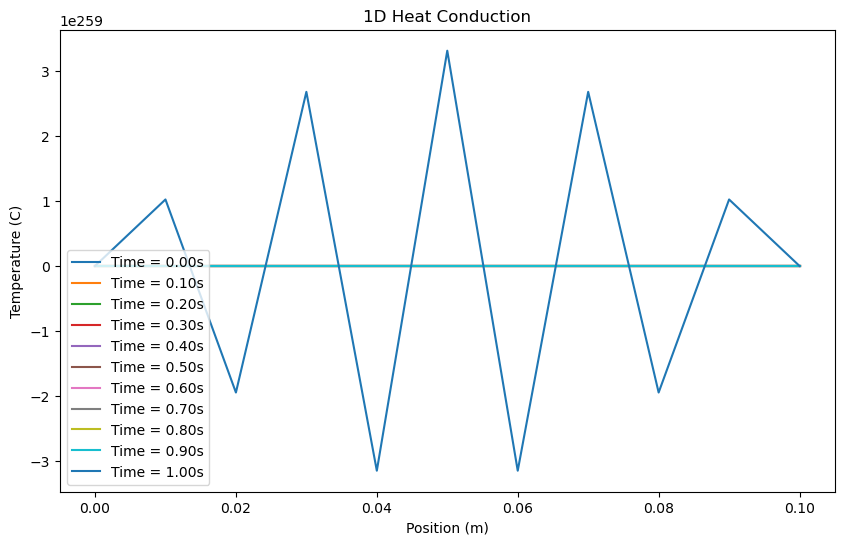

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def heat_conduction_1d(length, time, thermal_conductivity, initial_temperature, boundary_temperature):
    """
    Solve 1D heat conduction problem using explicit finite difference method.

    Parameters:
        length (float): Length of the material in meters.
        time (float): Total simulation time in seconds.
        thermal_conductivity (float): Thermal conductivity of the material.
        initial_temperature (float): Initial temperature of the material.
        boundary_temperature (float): Temperature at both boundaries.

    Returns:
        time_values (numpy.ndarray): Time values.
        temperature_profile (numpy.ndarray): Temperature profile at different time steps.
    """
    # Spatial and temporal step sizes
    dx = 0.01  # Spatial step size
    dt = 0.01  # Time step size

    # Number of spatial points and time steps
    num_points = int(length / dx) + 1
    num_steps = int(time / dt) + 1

    # Calculate the thermal diffusivity
    alpha = thermal_conductivity * dt / (dx ** 2)

    # Initialize temperature profile array
    temperature_profile = np.zeros((num_steps, num_points))
    time_values = np.linspace(0, time, num_steps)

    # Initial condition
    temperature_profile[0, :] = initial_temperature

    # Boundary conditions
    temperature_profile[:, 0] = boundary_temperature
    temperature_profile[:, -1] = boundary_temperature

    # Explicit finite difference method
    for i in range(1, num_steps):
        for j in range(1, num_points - 1):
            # Update temperature using the finite difference equation
            temperature_profile[i, j] = temperature_profile[i - 1, j] + \
                alpha * (temperature_profile[i - 1, j - 1] - 2 * temperature_profile[i - 1, j] +
                         temperature_profile[i - 1, j + 1])

    return time_values, temperature_profile

def plot_temperature_evolution(time_values, temperature_profile):
    """
    Plot the evolution of temperature over time.

    Parameters:
        time_values (numpy.ndarray): Time values.
        temperature_profile (numpy.ndarray): Temperature profile at different time steps.
    """
    plt.figure(figsize=(10, 6))
    plt.title('1D Heat Conduction')
    plt.xlabel('Position (m)')
    plt.ylabel('Temperature (C)')
    
    # Plot temperature profiles at different time steps
    for i in range(0, len(time_values), len(time_values)//10):
        plt.plot(np.linspace(0, length, len(temperature_profile[i, :])),
                 temperature_profile[i, :], label=f'Time = {time_values[i]:.2f}s')
    
    plt.legend()
    plt.show()

# Example usage
length = 0.1  # Length of the material (meters)
time = 1.0    # Total simulation time (seconds)
thermal_conductivity = 1.0  # Thermal conductivity (W/(m*K))
initial_temperature = 100.0  # Initial temperature (Celsius)
boundary_temperature = 0.0   # Temperature at boundaries (Celsius)

time_values, temperature_profile = heat_conduction_1d(length, time, thermal_conductivity,
                                                     initial_temperature, boundary_temperature)

plot_temperature_evolution(time_values, temperature_profile)

In [7]:
{
    "100-41-4": {
        "Tmax": 617.0582880000001, 
        "Tmin": 178.20000000000002, 
        "coefficients": [
            -9.748794210177854e-34, 
            6.374050667502966e-30, 
            -1.941431312777977e-26, 
            3.657570984505205e-23, 
            -4.7723392773104535e-20, 
            4.5754495374148144e-17, 
            -3.3369116249155326e-14, 
            1.890475015691761e-11, 
            -8.421101552569423e-09, 
            2.965699254965712e-06, 
            -0.0008255986016839614, 
            0.18061506227437618, 
            -30.667440023616784, 
            3956.3131466735977, 
            -374468.105944861, 
            24503603.79914395, 
            -989737269.3558804, 
            18580772768.64549
        ], 
        "error_average": 0.0038064827939922772, 
        "error_std": 0.006856345350741883, 
        "max_error": 0.05136172900455782, 
        "method": "COOLPROP"
    }, 
    "10024-97-2": {
        "Tmax": 309.48904799999997, 
        "Tmin": 182.33, 
        "coefficients": [
            -8.771083816200555e-19, 
            2.747427701312267e-15, 
            -3.960649069047366e-12, 
            3.4792001358191165e-09, 
            -2.0778219481848957e-06, 
            0.0008908662401633188, 
            -0.28211235583711125, 
            66.8081777885285, 
            -11831.328781691116, 
            1547527.0950254665, 
            -145315064.23219115, 
            9276588694.193035, 
            -360848951428.96295, 
            6459715741339.318
        ], 
        "error_average": 0.006680727412989683, 
        "error_std": 0.012002663074015025, 
        "max_error": 0.07361208013777332, 
        "method": "COOLPROP"
    }, 
    "102687-65-0": {
        "Tmax": 439.55604000000005, 
        "Tmin": 195.15, 
        "coefficients": [
            -5.780328141734293e-26, 
            2.6800896575530535e-22, 
            -5.767033193271822e-19, 
            7.63920672051365e-16, 
            -6.965995895077434e-13, 
            4.631625302584663e-10, 
            -2.3195304028359476e-07, 
            8.909068508167188e-05, 
            -0.02645894464846851, 
            6.075844169197801, 
            -1069.951671852922, 
            141895.42213255377, 
            -13718013.151793076, 
            912705452.4509699, 
            -37369350017.66141, 
            709800509632.3813
        ], 
        "error_average": 0.004659772013440859, 
        "error_std": 0.009100608400956892, 
        "max_error": 0.06072890743522974, 
        "method": "COOLPROP"
    }, 
    "106-42-3": {
        "Tmax": 616.1063832, 
        "Tmin": 286.40000000000003, 
        "coefficients": [
            -7.021580370538409e-28, 
            4.6357543612342345e-24, 
            -1.421210108606032e-20, 
            2.6837452874439825e-17, 
            -3.490775949040825e-14, 
            3.31270005117451e-11, 
            -2.3693439607561288e-08, 
            1.3005102163854675e-05, 
            -0.005523133871108662, 
            1.814817024159193, 
            -457.601943004921, 
            86951.25866564881, 
            -12052302.807527363, 
            1150452737.7221875, 
            -67623966050.73753, 
            1845248460453.664
        ], 
        "error_average": 0.0035934101125142813, 
        "error_std": 0.0066319474079880635, 
        "max_error": 0.042013213297974916, 
        "method": "COOLPROP"
    }, 
    "106-97-8": {
        "Tmax": 425.0824875, 
        "Tmin": 134.895, 
        "coefficients": [
            -6.004450805815017e-29, 
            2.6019851968043693e-25, 
            -5.235355053423971e-22, 
            6.490841478133045e-19, 
            -5.548852440777177e-16, 
            3.467455027269487e-13, 
            -1.6380924151768617e-10, 
            5.966705708371439e-08, 
            -1.6932278064119175e-05, 
            0.003755428704183404, 
            -0.6487339482793859, 
            86.35773645130288, 
            -8683.58504300695, 
            637581.6745532445, 
            -32236721.342808235, 
            1002805003.9684687, 
            -14459178498.171791
        ], 
        "error_average": 0.004337614478061018, 
        "error_std": 0.008088261418145719, 
        "max_error": 0.06468308628922559, 
        "method": "COOLPROP"
    }, 
    "106-98-9": {
        "Tmax": 419.24807100000004, 
        "Tmin": 87.80000000000001, 
        "coefficients": [
            -8.605012347194053e-34, 
            3.783195644284304e-30, 
            -7.748883856816746e-27, 
            9.819961839257073e-24, 
            -8.623920990968403e-21, 
            5.570556465451466e-18, 
            -2.7414466448446916e-15, 
            1.050485291695874e-12, 
            -3.1757621945097993e-10, 
            7.627611287735805e-08, 
            -1.4583230396983128e-05, 
            0.0022133037687039852, 
            -0.264583312550531, 
            24.567457871123292, 
            -1732.5051669333843, 
            89520.99432207822, 
            -3191358.8944637496, 
            70043091.57543355, 
            -712302103.9984022
        ], 
        "error_average": 0.0038329181568530694, 
        "error_std": 0.007353139838328539, 
        "max_error": 0.04834429666512463, 
        "method": "COOLPROP"
    }, 
    "107-46-0": {
        "Tmax": 518.698125, 
        "Tmin": 204.93, 
        "coefficients": [
            -2.5149925407869157e-29, 
            1.4160806377298157e-25, 
            -3.7129957089395503e-22, 
            6.017337377991617e-19, 
            -6.745517756062092e-16, 
            5.5458466013063e-13, 
            -3.4588113000201193e-10, 
            1.66912444281517e-07, 
            -6.298155251213384e-05, 
            0.018643151447919653, 
            -4.314603049656242, 
            772.4515530734042, 
            -104874.16879979918, 
            10438156.529110374, 
            -718264495.7849098, 
            30529740677.334473, 
            -603871794170.7002
        ], 
        "error_average": 0.004269040319316181, 
        "error_std": 0.008154815197207529, 
        "max_error": 0.06435361545922702, 
        "method": "COOLPROP"
    }, 
    "107-51-7": {
        "Tmax": 564.033591, 
        "Tmin": 187.2, 
        "coefficients": [
            -2.6583240921992222e-24, 
            1.2475111344441506e-20, 
            -2.671815407652525e-17, 
            3.456790600449988e-14, 
            -3.013470458123244e-11, 
            1.8686836881379638e-08, 
            -8.47830506111317e-06, 
            0.0028489935185814054, 
            -0.7089393504255233, 
            129.0063566439901, 
            -16685.06378092722, 
            1452380.8329908892, 
            -76265467.29783906, 
            1824749697.3716042
        ], 
        "error_average": 0.009195182660989103, 
        "error_std": 0.017867419305405224, 
        "max_error": 0.11647090065502053, 
        "method": "COOLPROP"
    }, 
    "107-52-8": {
        "Tmax": 653.13468, 
        "Tmin": 214.15, 
        "coefficients": [
            -1.5525709002357118e-31, 
            1.0427855318233644e-27, 
            -3.2534664190432546e-24, 
            6.2577620273944706e-21, 
            -8.303415036440618e-18, 
            8.058001009481155e-15, 
            -5.914998046233068e-12, 
            3.349626472365497e-09, 
            -1.478689449110919e-06, 
            0.0005104848655823814, 
            -0.1373474039953712, 
            28.494429161154954, 
            -4468.29170285423, 
            511969.4077518892, 
            -40421129.91873905, 
            1964750076.0990849, 
            -44294516693.5755
        ], 
        "error_average": 0.0034209063313295042, 
        "error_std": 0.006942052145837467, 
        "max_error": 0.05611014041326201, 
        "method": "COOLPROP"
    }, 
    "107-83-5": {
        "Tmax": 497.65023000000014, 
        "Tmin": 119.6, 
        "coefficients": [
            -8.728186289008401e-35, 
            4.682342337757694e-31, 
            -1.172256300737486e-27, 
            1.8191680813492798e-24, 
            -1.9602158591339813e-21, 
            1.5568564419540338e-18, 
            -9.441814794349707e-16, 
            4.4691757901414655e-13, 
            -1.6731886362797605e-10, 
            4.9900345709735297e-08, 
            -1.1879670834092705e-05, 
            0.0022516488145240235, 
            -0.3371748783245209, 
            39.34184815635432, 
            -3497.647795675187, 
            228594.59004801686, 
            -10342027.022325352, 
            289028009.2759217, 
            -3755342474.8429837
        ], 
        "error_average": 0.0031823621307281564, 
        "error_std": 0.0061627237560835865, 
        "max_error": 0.04296450120275641, 
        "method": "COOLPROP"
    }, 
    "108-38-3": {
        "Tmax": 616.828311, 
        "Tmin": 225.3, 
        "coefficients": [
            -5.963357993234124e-31, 
            3.899687599780534e-27, 
            -1.1863445343552519e-23, 
            2.2283106962547685e-20, 
            -2.891985108220064e-17, 
            2.7495833911121972e-14, 
            -1.980789750870106e-11, 
            1.1027908093567715e-08, 
            -4.7948890127406464e-06, 
            0.0016334353861745393, 
            -0.43449814126497055, 
            89.29391450339827, 
            -13898.109403279657, 
            1583713.3711784077, 
            -124603370.8814436, 
            6047672851.259781, 
            -136414012032.26492
        ], 
        "error_average": 0.003338681401917497, 
        "error_std": 0.006433584403243707, 
        "max_error": 0.0523799256745221, 
        "method": "COOLPROP"
    }, 
    "108-88-3": {
        "Tmax": 591.690825, 
        "Tmin": 178.0, 
        "coefficients": [
            -2.334504843989185e-33, 
            1.478629080367304e-29, 
            -4.365154665345283e-26, 
            7.97537248791565e-23, 
            -1.0097868997937532e-19, 
            9.400368988644244e-17, 
            -6.661220675557576e-14, 
            3.669237215572375e-11, 
            -1.590300512527537e-08, 
            5.45335559720126e-06, 
            -0.0014793241704383904, 
            0.31560689659132796, 
            -52.301763298337065, 
            6590.677882655415, 
            -609836.7904084671, 
            39043556.44736303, 
            -1544264774.9869277, 
            28412397157.93583
        ], 
        "error_average": 0.0037876279880260677, 
        "error_std": 0.007193516420015464, 
        "max_error": 0.054570371081780866, 
        "method": "COOLPROP"
    }, 
    "109-66-0": {
        "Tmax": 469.6530300000001, 
        "Tmin": 143.47, 
        "coefficients": [
            -1.171345595422892e-31, 
            5.91177373403657e-28, 
            -1.3909587943475424e-24, 
            2.0258812734328915e-21, 
            -2.0452105828074418e-18, 
            1.5184481304789638e-15, 
            -8.583445134228072e-13, 
            3.7726519919459316e-10, 
            -1.3050522141797068e-07, 
            3.572800519904307e-05, 
            -0.007739745695095801, 
            1.3190264655211281, 
            -174.6606303557801, 
            17591.810872466915, 
            -1301449.9025775506, 
            66639084.63493318, 
            -2108627282.6339104, 
            31046746244.857895
        ], 
        "error_average": 0.0039358452801380815, 
        "error_std": 0.007298626023305418, 
        "max_error": 0.056165661382232335, 
        "method": "COOLPROP"
    }, 
    "110-54-3": {
        "Tmax": 507.769218, 
        "Tmin": 177.83, 
        "coefficients": [
            -9.711509879213872e-30, 
            5.1649831943283164e-26, 
            -1.2771703863467169e-22, 
            1.9487589200557844e-19, 
            -2.0533272454722251e-16, 
            1.5839240404900024e-13, 
            -9.251824409017576e-11, 
            4.173602270538846e-08, 
            -1.4693478615987117e-05, 
            0.004050121683290381, 
            -0.8710831691549783, 
            144.63700601252998, 
            -18175.03915295809, 
            1670827.8658020808, 
            -105972314.87942687, 
            4143147477.8661375, 
            -75223545103.72859
        ], 
        "error_average": 0.004198537521923672, 
        "error_std": 0.008021443296997392, 
        "max_error": 0.0642989840107917, 
        "method": "COOLPROP"
    }, 
    "111-65-9": {
        "Tmax": 568.683126, 
        "Tmin": 216.37, 
        "coefficients": [
            -4.109966733065762e-30, 
            2.5081780163294446e-26, 
            -7.124472901781274e-23, 
            1.2501791538051958e-19, 
            -1.5166912811409705e-16, 
            1.3487491545006773e-13, 
            -9.093528591465383e-11, 
            4.741231445014347e-08, 
            -1.9317978849906774e-05, 
            0.00617102856492665, 
            -1.540312059339283, 
            297.2384555955323, 
            -43471.21068779149, 
            4657879.974254671, 
            -344834866.734248, 
            15759531053.037817, 
            -334958090195.7399
        ], 
        "error_average": 0.004224300563131398, 
        "error_std": 0.008178177299740602, 
        "max_error": 0.06586015167879578, 
        "method": "COOLPROP"
    }, 
    "111-84-2": {
        "Tmax": 594.4905450000001, 
        "Tmin": 219.7, 
        "coefficients": [
            -1.4417044359144937e-30, 
            9.117464447005433e-27, 
            -2.6827629298325004e-23, 
            4.874671191295491e-20, 
            -6.121209455682737e-17, 
            5.6319094773668535e-14, 
            -3.926929283682369e-11, 
            2.11648084355539e-08, 
            -8.910229306281043e-06, 
            0.0029395837438342043, 
            -0.7574105775203837, 
            150.8037610997357, 
            -22744.75131164227, 
            2512037.6928677144, 
            -191598773.15786335, 
            9016828684.315285, 
            -197249538963.18384
        ], 
        "error_average": 0.003871815222677566, 
        "error_std": 0.0072692652725692706, 
        "max_error": 0.05282043906416467, 
        "method": "COOLPROP"
    }, 
    "112-39-0": {
        "Tmax": 754.9245, 
        "Tmin": 302.71, 
        "coefficients": [
            -8.979922678383941e-32, 
            7.390717033478305e-28, 
            -2.833177932284397e-24, 
            6.7142139119483365e-21, 
            -1.1008813272294743e-17, 
            1.3241060254068035e-14, 
            -1.2083949944016233e-11, 
            8.534878425248271e-09, 
            -4.714653514869084e-06, 
            0.0020435549899713128, 
            -0.6926957395194093, 
            181.68233401702037, 
            -36145.612697952514, 
            5273059.891571831, 
            -531963015.9929433, 
            33157694897.819405, 
            -962001055913.5039
        ], 
        "error_average": 0.0029577250745447363, 
        "error_std": 0.006371407133119818, 
        "max_error": 0.049226573993328304, 
        "method": "COOLPROP"
    }, 
    "112-40-3": {
        "Tmax": 658.0341900000001, 
        "Tmin": 263.6, 
        "coefficients": [
            -7.13414950057944e-31, 
            5.1180898380273306e-27, 
            -1.7101497396378716e-23, 
            3.532496703006753e-20, 
            -5.04824998403449e-17, 
            5.292055930157007e-14, 
            -4.209200099827989e-11, 
            2.590984286695104e-08, 
            -1.247331618875011e-05, 
            0.004711630826246184, 
            -1.3917731007436127, 
            318.103178039326, 
            -55147.884593397735, 
            7010398.5188906, 
            -616250340.6485839, 
            33469176381.560738, 
            -846078591314.3002
        ], 
        "error_average": 0.0035212108192114815, 
        "error_std": 0.006367296803305008, 
        "max_error": 0.04805447001170804, 
        "method": "COOLPROP"
    }, 
    "112-61-8": {
        "Tmax": 774.9225, 
        "Tmin": 311.84000000000003, 
        "coefficients": [
            -9.620527484777347e-30, 
            7.613172060908606e-26, 
            -2.792478395076716e-22, 
            6.297090200444073e-19, 
            -9.762145238730948e-16, 
            1.1019600091640485e-12, 
            -9.3559487453736e-10, 
            6.083405661434208e-07, 
            -0.00030540280612472196, 
            0.11837014020874197, 
            -35.12977208374332, 
            7839.519523485816, 
            -1273363.0157358057, 
            142121479.80569494, 
            -9746329700.25903, 
            309591845444.28033
        ], 
        "error_average": 0.002989038625932121, 
        "error_std": 0.0051660150751698915, 
        "max_error": 0.03843626947461676, 
        "method": "COOLPROP"
    }, 
    "112-62-9": {
        "Tmax": 781.9218, 
        "Tmin": 253.47, 
        "coefficients": [
            -8.841067890170572e-33, 
            7.084306338499284e-29, 
            -2.6365718534863656e-25, 
            6.048412272036805e-22, 
            -9.57067330852307e-19, 
            1.1074065743058795e-15, 
            -9.69070638718452e-13, 
            6.540964758620017e-10, 
            -3.441020723191725e-07, 
            0.00014153874839106854, 
            -0.04536382765239334, 
            11.208776858621738, 
            -2092.9515150074444, 
            285489.3772586673, 
            -26828141.594159126, 
            1551790040.0809712, 
            -41622266659.739044
        ], 
        "error_average": 0.002620913489968385, 
        "error_std": 0.004643138189732396, 
        "max_error": 0.03696272076467566, 
        "method": "COOLPROP"
    }, 
    "112-63-0": {
        "Tmax": 798.9201, 
        "Tmin": 260.0, 
        "coefficients": [
            -8.153329007896806e-33, 
            6.684198683873614e-29, 
            -2.545245647163296e-25, 
            5.974303914470819e-22, 
            -9.67305072648821e-19, 
            1.1453118823122132e-15, 
            -1.0256279492763785e-12, 
            7.084633011480831e-10, 
            -3.814421183836415e-07, 
            0.00016058625657317652, 
            -0.05268188618079843, 
            13.32466594634279, 
            -2547.02049775268, 
            355686.77202652395, 
            -34221782.43238983, 
            2026792777.8566086, 
            -55666895571.482666
        ], 
        "error_average": 0.0035990843580978125, 
        "error_std": 0.006630312363393657, 
        "max_error": 0.05229664762552799, 
        "method": "COOLPROP"
    }, 
    "1120-21-4": {
        "Tmax": 638.73612, 
        "Tmin": 247.541, 
        "coefficients": [
            -8.4225895685904e-31, 
            5.80534920425161e-27, 
            -1.8629001816859936e-23, 
            3.6938892086678025e-20, 
            -5.06518256257732e-17, 
            5.092492745957083e-14, 
            -3.88285630119205e-11, 
            2.2900823326781484e-08, 
            -1.0558127687190878e-05, 
            0.0038174625902227524, 
            -1.0788146366606228, 
            235.7732971144247, 
            -39063.829419330184, 
            4743267.956055898, 
            -398061394.41740996, 
            20628367763.303673, 
            -497310186198.41675
        ], 
        "error_average": 0.0040642782338209385, 
        "error_std": 0.008034291881126674, 
        "max_error": 0.06443011673787558, 
        "method": "COOLPROP"
    }, 
    "115-10-6": {
        "Tmax": 400.3379622, 
        "Tmin": 131.66, 
        "coefficients": [
            -2.019992846185286e-30, 
            8.860339595592504e-27, 
            -1.8135614891353905e-23, 
            2.3001452748172327e-20, 
            -2.0242332073799283e-17, 
            1.3115405556411023e-14, 
            -6.477393839387754e-12, 
            2.4903418526214206e-09, 
            -7.54481099351547e-07, 
            0.00018112942684682132, 
            -0.03445350979995142, 
            5.162582268018066, 
            -601.8754078338611, 
            53446.645679659196, 
            -3490937.920317866, 
            158036828.45950437, 
            -4427454377.787663, 
            57796701260.0592
        ], 
        "error_average": 0.003485320042327692, 
        "error_std": 0.006558108191454173, 
        "max_error": 0.04658415246802505, 
        "method": "COOLPROP"
    }, 
    "115-11-7": {
        "Tmax": 418.048191, 
        "Tmin": 132.4, 
        "coefficients": [
            -7.344682934801746e-29, 
            3.1284422181334624e-25, 
            -6.18701153186941e-22, 
            7.539361645689669e-19, 
            -6.334644679573616e-16, 
            3.890465450398987e-13, 
            -1.8062851907223443e-10, 
            6.465836740634985e-08, 
            -1.803151345543721e-05, 
            0.0039299495903826025, 
            -0.6670959854613583, 
            87.25702662469038, 
            -8621.019096237242, 
            621925.6687968782, 
            -30894362.830333494, 
            944176485.114502, 
            -13374304500.487106
        ], 
        "error_average": 0.004258090255688753, 
        "error_std": 0.008147177307019927, 
        "max_error": 0.06561250158519982, 
        "method": "COOLPROP"
    }, 
    "124-18-5": {
        "Tmax": 617.63823, 
        "Tmin": 243.5, 
        "coefficients": [
            -1.5155010522299807e-28, 
            9.50087597973502e-25, 
            -2.759933514271565e-21, 
            4.9274890257776865e-18, 
            -6.046029791356477e-15, 
            5.399938163398404e-12, 
            -3.6263022407424263e-09, 
            1.8643538861381374e-06, 
            -0.0007397917706132642, 
            0.22655869296276732, 
            -53.10817440896059, 
            9357.654878973874, 
            -1199677.8543561918, 
            105645268.1512741, 
            -5714165170.963751, 
            143108998103.32602
        ], 
        "error_average": 0.0038477371425638105, 
        "error_std": 0.007370742448122935, 
        "max_error": 0.055208523285751765, 
        "method": "COOLPROP"
    }, 
    "124-38-9": {
        "Tmax": 304.09778718, 
        "Tmin": 216.592, 
        "coefficients": [
            -2.0957846057542933e-15, 
            6.454126420891924e-12, 
            -9.098034822860686e-09, 
            7.762665887727732e-06, 
            -0.0044649290584547, 
            1.8238621004253757, 
            -542.5408922917265, 
            118417.46847132893, 
            -18821865.174901422, 
            2124635362.0479078, 
            -161676969906.49918, 
            7446758482192.099, 
            -157003160923045.3
        ], 
        "error_average": 0.006126276266665012, 
        "error_std": 0.01103932615306544, 
        "max_error": 0.06834743784360597, 
        "method": "COOLPROP"
    }, 
    "1333-74-0": {
        "Tmax": 33.1416855, 
        "Tmin": 13.957, 
        "coefficients": [
            -9.829915489097033e-11, 
            3.376833095868403e-08, 
            -5.379985307965687e-06, 
            0.0005272807216718719, 
            -0.03554922321035264, 
            1.7462805824257468, 
            -64.56357595221723, 
            1829.3354714297016, 
            -40046.81854246433, 
            677317.9565596939, 
            -8777941.281971425, 
            85602926.6758352, 
            -608065667.8068798, 
            2970130406.8832803, 
            -8920576825.324327, 
            12419227927.392107
        ], 
        "error_average": 0.005012345044114891, 
        "error_std": 0.008752784608733955, 
        "max_error": 0.06331776468645511, 
        "method": "COOLPROP"
    }, 
    "141-62-8": {
        "Tmax": 599.34006, 
        "Tmin": 205.2, 
        "coefficients": [
            -1.145816386889591e-30, 
            7.14678655990711e-27, 
            -2.0719138706466536e-23, 
            3.705300144351659e-20, 
            -4.574267091381453e-17, 
            4.1328129439684356e-14, 
            -2.826385109151468e-11, 
            1.492268245069739e-08, 
            -6.146485566673071e-06, 
            0.001981375971970414, 
            -0.4981743946830257, 
            96.66012912745055, 
            -14187.64162695637, 
            1522833.7594872613, 
            -112724221.80150005, 
            5141350979.166884, 
            -108853221682.53293
        ], 
        "error_average": 0.0050717305802744994, 
        "error_std": 0.009037150373279157, 
        "max_error": 0.07105540630376206, 
        "method": "COOLPROP"
    }, 
    "141-63-9": {
        "Tmax": 627.9372, 
        "Tmin": 192.0, 
        "coefficients": [
            -1.8173103196926265e-31, 
            1.1520582970228912e-27, 
            -3.3892545022763174e-24, 
            6.14058947689949e-21, 
            -7.666795216370853e-18, 
            6.9929729362461565e-15, 
            -4.818998427961525e-12, 
            2.558799369712565e-09, 
            -1.0578048633504296e-06, 
            0.0003415339581275317, 
            -0.08582469620982283, 
            16.607260100856465, 
            -2425.6097184127766, 
            258495.3539993829, 
            -18955289.91645529, 
            854526891.0935248, 
            -17842235760.2931
        ], 
        "error_average": 0.0038010372647055406, 
        "error_std": 0.007463879441229026, 
        "max_error": 0.06013929709307786, 
        "method": "COOLPROP"
    }, 
    "142-82-5": {
        "Tmax": 540.075987, 
        "Tmin": 182.55, 
        "coefficients": [
            -5.621199158351653e-33, 
            3.349401556882771e-29, 
            -9.316490484378082e-26, 
            1.6063876133831798e-22, 
            -1.9226877125215817e-19, 
            1.694990884018788e-16, 
            -1.1394984362996394e-13, 
            5.966179580025985e-11, 
            -2.4626983649602277e-08, 
            8.059051962144931e-06, 
            -0.0020906029095085297, 
            0.42742812602111396, 
            -68.02660011681469, 
            8250.666760493357, 
            -736425.8264486342, 
            45581221.717860185, 
            -1746806191.77634, 
            31208879909.29867
        ], 
        "error_average": 0.0007040950753368422, 
        "error_std": 0.0011817987214452017, 
        "max_error": 0.00858547939594101, 
        "method": "COOLPROP"
    }, 
    "2551-62-4": {
        "Tmax": 318.69132768000003, 
        "Tmin": 223.555, 
        "coefficients": [
            -9.25604510437988e-16, 
            2.966652518101207e-12, 
            -4.351866582827858e-09, 
            3.863543453003488e-06, 
            -0.0023119817447770762, 
            0.9824368602417968, 
            -303.9735131385497, 
            69001.32395028083, 
            -11404873.550440384, 
            1338585816.8116245, 
            -105899010004.56139, 
            5070385736497.726, 
            -111111847249919.31
        ], 
        "error_average": 0.007261153801538031, 
        "error_std": 0.01277547355307124, 
        "max_error": 0.0788590988150435, 
        "method": "COOLPROP"
    }, 
    "2837-89-0": {
        "Tmax": 395.38545750000003, 
        "Tmin": 120.0, 
        "coefficients": [
            -1.355295752418722e-28, 
            5.39969172536433e-25, 
            -9.982561623128774e-22, 
            1.13642952375058e-18, 
            -8.91435176712581e-16, 
            5.107725827640848e-13, 
            -2.2108347514086893e-10, 
            7.372437707540225e-08, 
            -1.913794170495638e-05, 
            0.0038794999153367793, 
            -0.6119866198572114, 
            74.32750161813881, 
            -6812.825603945901, 
            455560.3896753454, 
            -20957627.708118893, 
            592635286.4678625, 
            -7760571230.440697
        ], 
        "error_average": 0.004116830913575613, 
        "error_std": 0.007860592058517012, 
        "max_error": 0.06289786055961599, 
        "method": "COOLPROP"
    }, 
    "287-92-3": {
        "Tmax": 511.668828, 
        "Tmin": 179.70000000000002, 
        "coefficients": [
            -4.5281463397179845e-30, 
            2.4285701912596313e-26, 
            -6.056143257178242e-23, 
            9.31942558103597e-20, 
            -9.903569952183077e-17, 
            7.705308497372567e-14, 
            -4.5396803321079605e-11, 
            2.065722068011124e-08, 
            -7.336174774258537e-06, 
            0.002039948001785952, 
            -0.4426279347450507, 
            74.14968727604132, 
            -9401.101669980713, 
            872030.2556189734, 
            -55809963.3490089, 
            2201872512.57226, 
            -40344164433.79344
        ], 
        "error_average": 0.002599172855094581, 
        "error_std": 0.005352932060258566, 
        "max_error": 0.04450342556574727, 
        "method": "COOLPROP"
    }, 
    "29118-24-9": {
        "Tmax": 382.481748, 
        "Tmin": 168.62, 
        "coefficients": [
            -3.632205075405527e-25, 
            1.4620290129932749e-21, 
            -2.7309167480269647e-18, 
            3.139880343199423e-15, 
            -2.4849368558648235e-12, 
            1.433806068066075e-09, 
            -6.230725297896431e-07, 
            0.0002076386932412109, 
            -0.05349845030688918, 
            10.6566986597242, 
            -1627.7279737499757, 
            187215.39885957222, 
            -15695445.039690536, 
            905473952.335185, 
            -32142340295.382595, 
            529259722646.64355
        ], 
        "error_average": 0.00399825948270452, 
        "error_std": 0.007074367850361885, 
        "max_error": 0.05090297315313985, 
        "method": "COOLPROP"
    }, 
    "29118-25-0": {
        "Tmax": 423.227673, 
        "Tmin": 273.0, 
        "coefficients": [
            -1.861774402083791e-14, 
            6.339344263430798e-11, 
            -9.687898025389877e-08, 
            8.75030326866734e-05, 
            -0.051729219016107886, 
            20.914183785969975, 
            -5856.425638337004, 
            1121548.773374059, 
            -140580871.69075805, 
            10414717651.303797, 
            -346292536329.321
        ], 
        "error_average": 0.016166465114329304, 
        "error_std": 0.03549207735238759, 
        "max_error": 0.3128198477901333, 
        "method": "COOLPROP"
    }, 
    "301-00-8": {
        "Tmax": 771.9228, 
        "Tmin": 260.0, 
        "coefficients": [
            -1.0659542136292943e-34, 
            9.072881115821694e-31, 
            -3.60470871767077e-27, 
            8.877258750278817e-24, 
            -1.5174637220360622e-20, 
            1.9104152505155677e-17, 
            -1.8339787105062835e-14, 
            1.3710896585106272e-11, 
            -8.08049814296258e-09, 
            3.7751679368750804e-06, 
            -0.001398031639091205, 
            0.4080084638993972, 
            -92.68571983756783, 
            16044.212806653213, 
            -2043718.4758590555, 
            180512915.31266302, 
            -9871090928.891611, 
            251631221279.69733
        ], 
        "error_average": 0.002511264781785189, 
        "error_std": 0.004744820347372987, 
        "max_error": 0.03793789817600701, 
        "method": "COOLPROP"
    }, 
    "306-83-2": {
        "Tmax": 456.7853169, 
        "Tmin": 166.0, 
        "coefficients": [
            -6.822050179158529e-29, 
            3.2988701006026443e-25, 
            -7.420412301706367e-22, 
            1.0304905926560883e-18, 
            -9.887433185130857e-16, 
            6.949293645270658e-13, 
            -3.7005338879771705e-10, 
            1.52277721559333e-07, 
            -4.893314123150425e-05, 
            0.012318875500468434, 
            -2.4213867539607286, 
            367.67764456111195, 
            -42279.687598909695, 
            3559136.0138055505, 
            -206847800.20175654, 
            7415214469.987364, 
            -123529349942.51414
        ], 
        "error_average": 0.0048158492360672, 
        "error_std": 0.009016528470709786, 
        "max_error": 0.06087842977383162, 
        "method": "COOLPROP"
    }, 
    "353-36-6": {
        "Tmax": 375.212475, 
        "Tmin": 130.0, 
        "coefficients": [
            -6.314218822088889e-28, 
            2.4738212625870215e-24, 
            -4.505596020304209e-21, 
            5.0629103568087385e-18, 
            -3.92799550004465e-15, 
            2.2307308032738962e-12, 
            -9.59106743336749e-10, 
            3.184209929794149e-07, 
            -8.24875492849024e-05, 
            0.016727268860551623, 
            -2.646232870008938, 
            323.1291540897291, 
            -29854.92817429844, 
            2017582.150110767, 
            -94051397.03105144, 
            2702034939.4689436, 
            -36042652049.81441
        ], 
        "error_average": 0.0035459362901093055, 
        "error_std": 0.006742193891880622, 
        "max_error": 0.05416960067263066, 
        "method": "COOLPROP"
    }, 
    "354-33-6": {
        "Tmax": 339.1390827, 
        "Tmin": 172.52, 
        "coefficients": [
            -1.476922000896875e-23, 
            5.543242846560448e-20, 
            -9.671079002993898e-17, 
            1.0403832247768689e-13, 
            -7.717576643110633e-11, 
            4.1814616619559196e-08, 
            -1.7094209654880648e-05, 
            0.005369135701477583, 
            -1.3063111501961266, 
            246.18980383419347, 
            -35646.000704381324, 
            3894008.5303211366, 
            -310672693.85398024, 
            17089456094.83339, 
            -579562336627.2661, 
            9134949623295.902
        ], 
        "error_average": 0.004655086289115069, 
        "error_std": 0.008272793709666437, 
        "max_error": 0.0513124457379357, 
        "method": "COOLPROP"
    }, 
    "406-58-6": {
        "Tmax": 459.954, 
        "Tmin": 239.0, 
        "coefficients": [
            -1.7881223173934308e-23, 
            8.548798395762997e-20, 
            -1.8900401642489394e-16, 
            2.561191105815349e-13, 
            -2.3764630262251235e-10, 
            1.597171331257049e-07, 
            -8.017843692317386e-05, 
            0.030540825137008308, 
            -8.870136618207644, 
            1954.7286884317507, 
            -321741.7773489367, 
            38355597.24623523, 
            -3130597124.0217686, 
            156595766509.421, 
            -3621855864173.074
        ], 
        "error_average": 0.005258913927995451, 
        "error_std": 0.009040234061170657, 
        "max_error": 0.046184849559341545, 
        "method": "COOLPROP"
    }, 
    "421-14-7": {
        "Tmax": 377.8832079, 
        "Tmin": 240.0, 
        "coefficients": [
            -1.6420860551941933e-17, 
            5.97275440514772e-14, 
            -9.934192586945012e-11, 
            9.99081263874201e-08, 
            -6.766503627843066e-05, 
            0.032512825402201954, 
            -11.364752561048295, 
            2911.7837991066885, 
            -542716.000080979, 
            71764882.53470206, 
            -6390650348.152202, 
            344101391660.62964, 
            -8472361512100.14
        ], 
        "error_average": 0.007905735073624565, 
        "error_std": 0.014876063364516462, 
        "max_error": 0.10765685830428617, 
        "method": "COOLPROP"
    }, 
    "460-73-1": {
        "Tmax": 426.96729899999997, 
        "Tmin": 171.05, 
        "coefficients": [
            -4.0421536513487965e-28, 
            1.881646827715127e-24, 
            -4.079661751424035e-21, 
            5.4680418189389826e-18, 
            -5.070504952188331e-15, 
            3.4490171340243443e-12, 
            -1.7800465340564924e-09, 
            7.109805624898852e-07, 
            -0.0002220937663555454, 
            0.05443616494092429, 
            -10.433905261167737, 
            1547.4228648392698, 
            -174073.5512187528, 
            14358529.168199478, 
            -819007974.9465437, 
            28862908559.11747, 
            -473445827103.01544
        ], 
        "error_average": 0.003538385798826566, 
        "error_std": 0.0064574900813573095, 
        "max_error": 0.047558949164065334, 
        "method": "COOLPROP"
    }, 
    "463-58-1": {
        "Tmax": 378.732123, 
        "Tmin": 134.3, 
        "coefficients": [
            -7.158314295893444e-28, 
            2.8496187599977425e-24, 
            -5.2751364763384754e-21, 
            6.026793497698289e-18, 
            -4.755641742642066e-15, 
            2.7478342436520193e-12, 
            -1.202469690166648e-09, 
            4.0647747293867467e-07, 
            -0.00010725543940523659, 
            0.022162815697438887, 
            -3.5741559847742956, 
            445.0889438971425, 
            -41955.99149816969, 
            2894011.1487145047, 
            -137755773.855867, 
            4042925420.494635, 
            -55114485802.706215
        ], 
        "error_average": 0.004345494432337402, 
        "error_std": 0.007956667636409273, 
        "max_error": 0.0628359042014277, 
        "method": "COOLPROP"
    }, 
    "463-82-1": {
        "Tmax": 433.69662600000004, 
        "Tmin": 256.6, 
        "coefficients": [
            -1.671931457379107e-20, 
            7.351832846010518e-17, 
            -1.4878500646789134e-13, 
            1.834911906892356e-10, 
            -1.5385333059615023e-07, 
            9.261765632130303e-05, 
            -0.041181883680161235, 
            13.694203120298804, 
            -3405.524555102315, 
            625536.2483833393, 
            -82491458.21058047, 
            7395902095.323901, 
            -404066785505.5751, 
            10159825098847.814
        ], 
        "error_average": 0.00675081277955, 
        "error_std": 0.012054353199891708, 
        "max_error": 0.06826697818600036, 
        "method": "COOLPROP"
    }, 
    "540-97-6": {
        "Tmax": 645.715422, 
        "Tmin": 270.2, 
        "coefficients": [
            -2.1261847526514363e-30, 
            1.5176669849549554e-26, 
            -5.0483277820342926e-23, 
            1.0386817873738338e-19, 
            -1.4793764311162363e-16, 
            1.5465216433174703e-13, 
            -1.2274053511287592e-10, 
            7.543609727894682e-08, 
            -3.628247619782614e-05, 
            0.013701438063708363, 
            -4.048803337945004, 
            926.3526401128274, 
            -160870.53769866627, 
            20498426.565186232, 
            -1807410177.4488087, 
            98527552268.11111, 
            -2501651556546.634
        ], 
        "error_average": 0.004385043964039165, 
        "error_std": 0.008494042959855517, 
        "max_error": 0.06759016928898731, 
        "method": "COOLPROP"
    }, 
    "556-67-2": {
        "Tmax": 586.44135, 
        "Tmin": 290.25, 
        "coefficients": [
            -5.3979507424874295e-25, 
            3.23173843668406e-21, 
            -8.942296764882118e-18, 
            1.515686328232574e-14, 
            -1.7580264090846244e-11, 
            1.4760675835612651e-08, 
            -9.251291558789817e-06, 
            0.004396853460847609, 
            -1.5923249284112662, 
            437.2699893294059, 
            -89629.84172257007, 
            13297662.079777997, 
            -1349877399.9932346, 
            83924256408.60117, 
            -2411014810329.2534
        ], 
        "error_average": 0.005693164795888816, 
        "error_std": 0.010220264647250973, 
        "max_error": 0.05952087463069966, 
        "method": "COOLPROP"
    }, 
    "590-18-1": {
        "Tmax": 435.706425, 
        "Tmin": 134.3, 
        "coefficients": [
            -3.3594145470995767e-29, 
            1.4808369451319063e-25, 
            -3.0295866265701435e-22, 
            3.8175654271319805e-19, 
            -3.315439074872271e-16, 
            2.1037591800310112e-13, 
            -1.0086879063895571e-10, 
            3.727035477841862e-08, 
            -1.0723188203210707e-05, 
            0.002409957408840779, 
            -0.42161190205669735, 
            56.805890925473996, 
            -5778.061356285998, 
            428895.82128918206, 
            -21909876.94553124, 
            688206049.0102445, 
            -10013799741.0676
        ], 
        "error_average": 0.00440367479541379, 
        "error_std": 0.008315778281444103, 
        "max_error": 0.06704092584480015, 
        "method": "COOLPROP"
    }, 
    "593-53-3": {
        "Tmax": 317.24827200000004, 
        "Tmin": 129.82, 
        "coefficients": [
            -2.199767874431704e-24, 
            7.16736089927414e-21, 
            -1.0826480092753768e-17, 
            1.0056182448802015e-14, 
            -6.422880289427799e-12, 
            2.987725829238891e-09, 
            -1.0455753347477654e-06, 
            0.00028029288801358526, 
            -0.05802885764945218, 
            9.277459928097082, 
            -1136.0315143794212, 
            104627.62591290828, 
            -7015617.83587539, 
            323329815.10256135, 
            -9158308444.866188, 
            120189698886.18054
        ], 
        "error_average": 0.004663509883596639, 
        "error_std": 0.008441105713236929, 
        "max_error": 0.06191926722940533, 
        "method": "COOLPROP"
    }, 
    "616-38-6": {
        "Tmax": 556.9443, 
        "Tmin": 277.06, 
        "coefficients": [
            -7.621039861234135e-25, 
            4.340959048961433e-21, 
            -1.1428556217649795e-17, 
            1.8432047597359387e-14, 
            -2.0344229089459783e-11, 
            1.6255627694616257e-08, 
            -9.696432392595433e-06, 
            0.004386260991497168, 
            -1.5120218680436115, 
            395.25845707862777, 
            -77129.51366098732, 
            10894595.58196214, 
            -1053002430.7383544, 
            62338025996.257324, 
            -1705402976429.445
        ], 
        "error_average": 0.004581955058130611, 
        "error_std": 0.007867998394124855, 
        "max_error": 0.046373330871438245, 
        "method": "COOLPROP"
    }, 
    "624-64-6": {
        "Tmax": 428.567139, 
        "Tmin": 167.60000000000002, 
        "coefficients": [
            -3.158538380115651e-28, 
            1.4648199437314075e-24, 
            -3.1630819176218718e-21, 
            4.2210556216800975e-18, 
            -3.895846411714106e-15, 
            2.636704804420855e-12, 
            -1.3535155048255751e-09, 
            5.375288663041459e-07, 
            -0.0001668920702926431, 
            0.04064266822249826, 
            -7.7370332050438515, 
            1139.2128976703332, 
            -127183.51732355515, 
            10407416.97970973, 
            -588692357.5123856, 
            20565534899.997993, 
            -334274213672.56964
        ], 
        "error_average": 0.004507027735564827, 
        "error_std": 0.008208487641632225, 
        "max_error": 0.06006232554824664, 
        "method": "COOLPROP"
    }, 
    "630-08-0": {
        "Tmax": 132.84671400000002, 
        "Tmin": 68.16, 
        "coefficients": [
            -1.258967133231144e-16, 
            1.7302258627470987e-13, 
            -1.0994737477594244e-10, 
            4.2816015555178566e-08, 
            -1.1415079978559227e-05, 
            0.0022040183906175724, 
            -0.3178106025158135, 
            34.767155168886035, 
            -2899.5203528901993, 
            183450.61970248903, 
            -8667743.247546231, 
            296566489.10706973, 
            -6946148860.690609, 
            99689511170.5018, 
            -661427754318.0393
        ], 
        "error_average": 0.005773038620840202, 
        "error_std": 0.010283597652375756, 
        "max_error": 0.06208874406134379, 
        "method": "COOLPROP"
    }, 
    "64-17-5": {
        "Tmax": 514.658529, 
        "Tmin": 159.10000000000002, 
        "coefficients": [
            -4.3179814499082885e-30, 
            2.249497316351139e-26, 
            -5.439331277826505e-23, 
            8.101326778915162e-20, 
            -8.316539454879155e-17, 
            6.23813443132686e-14, 
            -3.5358879988850466e-11, 
            1.544595346814014e-08, 
            -5.254262226677912e-06, 
            0.0013962443009815618, 
            -0.28883988406407746, 
            46.02123511929857, 
            -5536.001650522244, 
            486008.39358016016, 
            -29365581.98389877, 
            1091070492.2261982, 
            -18780116681.26971
        ], 
        "error_average": 0.004166989884362092, 
        "error_std": 0.007356186402451717, 
        "max_error": 0.05729111700056633, 
        "method": "COOLPROP"
    }, 
    "67-56-1": {
        "Tmax": 512.44875, 
        "Tmin": 175.61, 
        "coefficients": [
            -1.1193262643683301e-32, 
            6.353359642206286e-29, 
            -1.6837199289986493e-25, 
            2.766465579544429e-22, 
            -3.155880609120104e-19, 
            2.652154673255101e-16, 
            -1.7000077115683254e-13, 
            8.488447764928007e-11, 
            -3.3421817592654386e-08, 
            1.0434809254873916e-05, 
            -0.0025831590861537706, 
            0.5041053001178148, 
            -76.5978994428379, 
            8871.762063917513, 
            -756373.7492859353, 
            44728510.75382076, 
            -1638093912.403012, 
            27975123749.6987
        ], 
        "error_average": 0.0005147252323044928, 
        "error_std": 0.000917109052511085, 
        "max_error": 0.006579379870139013, 
        "method": "COOLPROP"
    }, 
    "67-64-1": {
        "Tmax": 508.04919, 
        "Tmin": 178.5, 
        "coefficients": [
            -9.550313104617449e-32, 
            5.414680553527457e-28, 
            -1.4337491815023045e-24, 
            2.3544752535962576e-21, 
            -2.685298804538615e-18, 
            2.2569279402929243e-15, 
            -1.4473243107462204e-12, 
            7.232595365341698e-10, 
            -2.8510630392821547e-07, 
            8.915317782358515e-05, 
            -0.02211301694206623, 
            4.325490593234946, 
            -659.0587573861803, 
            76575.3108569958, 
            -6551899.66184021, 
            388999089.5320276, 
            -14309292551.881794, 
            245554287624.07635
        ], 
        "error_average": 0.003942231801552169, 
        "error_std": 0.007509831525579074, 
        "max_error": 0.047074634116822, 
        "method": "COOLPROP"
    }, 
    "71-43-2": {
        "Tmax": 561.963798, 
        "Tmin": 278.674, 
        "coefficients": [
            -5.881745316828431e-25, 
            3.3767360417056776e-21, 
            -8.95992356599047e-18, 
            1.4563634751176186e-14, 
            -1.619951992014972e-11, 
            1.3043992701371337e-08, 
            -7.840533680794767e-06, 
            0.003573845076291742, 
            -1.2413307737609822, 
            326.9484606256681, 
            -64278.80609551557, 
            9147191.785097834, 
            -890668118.8287313, 
            53116555791.606766, 
            -1463776535287.9827
        ], 
        "error_average": 0.0050703167809493434, 
        "error_std": 0.00920210928764135, 
        "max_error": 0.053526066102151715, 
        "method": "COOLPROP"
    }, 
    "74-82-8": {
        "Tmax": 190.54494359999998, 
        "Tmin": 90.6941, 
        "coefficients": [
            -3.591316661216889e-19, 
            6.888535610224435e-16, 
            -6.10370527137419e-13, 
            3.3112387541610725e-10, 
            -1.2286312957873412e-07, 
            3.298310823071276e-05, 
            -0.0066061323548977985, 
            1.002798385422445, 
            -115.92965025943799, 
            10157.013706010375, 
            -663870.4632251965, 
            31389202.27039512, 
            -1014923345.9388288, 
            20087245832.50069, 
            -183606396457.5221
        ], 
        "error_average": 0.005124033223541789, 
        "error_std": 0.009032305175802913, 
        "max_error": 0.053286713100882954, 
        "method": "COOLPROP"
    }, 
    "74-84-0": {
        "Tmax": 305.2914678, 
        "Tmin": 90.368, 
        "coefficients": [
            -7.164151388154911e-29, 
            2.3317073353040293e-25, 
            -3.5364417701600277e-22, 
            3.3187325300118367e-19, 
            -2.1577580507670355e-16, 
            1.0312453564767681e-13, 
            -3.750614730637542e-11, 
            1.0600799142615578e-08, 
            -2.356862670738623e-06, 
            0.00041446222926707894, 
            -0.05763953274161768, 
            6.302400456079182, 
            -535.1084513218176, 
            34536.85701493212, 
            -1636263.615071439, 
            53620980.70796692, 
            -1085204413.6102858, 
            10213189431.532715
        ], 
        "error_average": 0.0037462329773395838, 
        "error_std": 0.006839973842885644, 
        "max_error": 0.053296297834919626, 
        "method": "COOLPROP"
    }, 
    "74-85-1": {
        "Tmax": 282.321765, 
        "Tmin": 103.989, 
        "coefficients": [
            -7.26932216132179e-26, 
            2.181118526247821e-22, 
            -3.0447750964613843e-19, 
            2.624614321850116e-16, 
            -1.5634480781203637e-13, 
            6.823482366669839e-11, 
            -2.25675886374992e-08, 
            5.7690587804544064e-06, 
            -0.0011518989191376294, 
            0.18022790032775982, 
            -22.02184250640117, 
            2079.1968977649776, 
            -148696.44861750616, 
            7786748.461292332, 
            -281583933.7480082, 
            6282445330.126434, 
            -65151648181.332344
        ], 
        "error_average": 0.0038524626808139877, 
        "error_std": 0.006946313078130305, 
        "max_error": 0.054608767898169264, 
        "method": "COOLPROP"
    }, 
    "74-87-3": {
        "Tmax": 416.25837, 
        "Tmin": 230.0, 
        "coefficients": [
            -1.399609810580634e-20, 
            5.748395402934211e-17, 
            -1.0857757245493456e-13, 
            1.2487894124018336e-10, 
            -9.757377778399241e-08, 
            5.469253806146872e-05, 
            -0.02262567892208317, 
            6.9942981149032395, 
            -1615.6697478639853, 
            275442.234530166, 
            -33685612.39635353, 
            2798544951.300166, 
            -141562805667.89664, 
            3292971069700.6665
        ], 
        "error_average": 0.012006878987943509, 
        "error_std": 0.02261388376502871, 
        "max_error": 0.1429393130865645, 
        "method": "COOLPROP"
    }, 
    "74-98-6": {
        "Tmax": 369.853011, 
        "Tmin": 85.525, 
        "coefficients": [
            -1.0763614883849019e-32, 
            4.2571972294129313e-29, 
            -7.85414622588401e-26, 
            8.977185199404977e-23, 
            -7.120698050786414e-20, 
            4.1606733706812795e-17, 
            -1.8552238563578457e-14, 
            6.452196899831542e-12, 
            -1.7736263089200472e-09, 
            3.8809672456353156e-07, 
            -6.773720266903672e-05, 
            0.009405094177653131, 
            -1.0308556664552555, 
            87.96442480812574, 
            -5714.240990961147, 
            272641.8215751149, 
            -8996759.618434269, 
            183224272.2034122, 
            -1733262365.8959038
        ], 
        "error_average": 0.0035310504085366025, 
        "error_std": 0.006910966320464516, 
        "max_error": 0.04750770106751956, 
        "method": "COOLPROP"
    }, 
    "74-99-7": {
        "Tmax": 402.339762, 
        "Tmin": 273.0, 
        "coefficients": [
            -1.4480343160023822e-17, 
            5.770730583191985e-14, 
            -1.0522885796149922e-10, 
            1.1609778544872871e-07, 
            -8.631463328254855e-05, 
            0.04555636834071951, 
            -17.502767795153716, 
            4932.155909977376, 
            -1011719.0260777388, 
            147328708.17498058, 
            -14457277396.54781, 
            858363027377.6124, 
            -23318897648776.566
        ], 
        "error_average": 0.0032563515411128097, 
        "error_std": 0.005414828207396774, 
        "max_error": 0.02863523334966811, 
        "method": "COOLPROP"
    }, 
    "7439-90-9": {
        "Tmax": 209.45905199999999, 
        "Tmin": 115.77, 
        "coefficients": [
            -2.4998646086311812e-17, 
            5.1657508511457916e-14, 
            -4.909203430947976e-11, 
            2.8408661689263764e-08, 
            -1.1168420619606947e-05, 
            0.0031498511337241376, 
            -0.6556513230243062, 
            101.98369001586903, 
            -11853.869872938016, 
            1016868.1013227836, 
            -62576381.642071016, 
            2615985959.44412, 
            -66587766736.063614, 
            779435622532.4515
        ], 
        "error_average": 0.006260657573636395, 
        "error_std": 0.011271897445580941, 
        "max_error": 0.06891087737249857, 
        "method": "COOLPROP"
    }, 
    "7440-01-9": {
        "Tmax": 44.395559999999996, 
        "Tmin": 24.56, 
        "coefficients": [
            -5.019145476331337e-10, 
            2.3721997732293467e-07, 
            -5.1884220727538386e-05, 
            0.00696039394419362, 
            -0.6398299402791168, 
            42.63290052570875, 
            -2123.4041727401973, 
            80308.6722379422, 
            -2317639.918285471, 
            50788498.08119982, 
            -831917153.85582, 
            9877026942.23338, 
            -80349029213.76233, 
            400885044960.6717, 
            -925521478382.7144
        ], 
        "error_average": 0.005366728709112458, 
        "error_std": 0.009395420746822758, 
        "max_error": 0.056483301272278075, 
        "method": "COOLPROP"
    }, 
    "7440-37-1": {
        "Tmax": 150.6719313, 
        "Tmin": 83.806, 
        "coefficients": [
            -7.332649031612648e-17, 
            1.178721024590847e-13, 
            -8.76896026962359e-11, 
            4.001514816663299e-08, 
            -1.2512903645389405e-05, 
            0.0028363956105209873, 
            -0.4806275968268253, 
            61.84699005047866, 
            -6073.070745728037, 
            452856.2077597449, 
            -25242597.428989235, 
            1019919030.1149211, 
            -28237879870.901386, 
            479523360302.0455, 
            -3768263475079.1587
        ], 
        "error_average": 0.005868902303479559, 
        "error_std": 0.011102459549617296, 
        "max_error": 0.06149086097941292, 
        "method": "COOLPROP"
    }, 
    "7440-59-7": {
        "Tmax": 5.19478047, 
        "Tmin": 2.1768, 
        "coefficients": [
            -14.463136751613051, 
            830.9022432983761, 
            -22245.43129030726, 
            368386.5212825076, 
            -4223146.281477721, 
            35535146.783858575, 
            -227009192.64744282, 
            1123043962.6108956, 
            -4347959689.612542, 
            13217059153.367405, 
            -31440149120.757217, 
            57907218051.70309, 
            -80954419822.80597, 
            83042713765.7906, 
            -58947301202.36209, 
            25870229363.146515, 
            -5288273298.779226
        ], 
        "error_average": 0.004367226663030038, 
        "error_std": 0.0073193406952884975, 
        "max_error": 0.05313015676132937, 
        "method": "COOLPROP"
    }, 
    "7440-63-3": {
        "Tmax": 289.7040267, 
        "Tmin": 161.4, 
        "coefficients": [
            -1.6371040320514765e-20, 
            5.063143149387783e-17, 
            -7.24700823829055e-14, 
            6.362742397268181e-11, 
            -3.828204642619972e-08, 
            1.669663453169402e-05, 
            -0.005443822539685034, 
            1.3478917967352098, 
            -254.67958941603493, 
            36542.95230033639, 
            -3919611.6259815963, 
            304753409.4540595, 
            -16236672465.033684, 
            530597183908.27844, 
            -8024071467623.702
        ], 
        "error_average": 0.006200221807260269, 
        "error_std": 0.011987934685018162, 
        "max_error": 0.06819888408483354, 
        "method": "COOLPROP"
    }, 
    "7446-09-5": {
        "Tmax": 430.59693599999997, 
        "Tmin": 197.7, 
        "coefficients": [
            -1.0928472197193848e-25, 
            5.020832134735384e-22, 
            -1.0709753813549117e-18, 
            1.4068960137879669e-15, 
            -1.2728412573470428e-12, 
            8.40033453326916e-10, 
            -4.1776697488518775e-07, 
            0.00015941876584175, 
            -0.047060664976641256, 
            10.74678161940794, 
            -1882.921082183786, 
            248567.24463732782, 
            -23932419.36274875, 
            1586567519.271343, 
            -64757245546.60593, 
            1226776810915.0193
        ], 
        "error_average": 0.004443073174290754, 
        "error_std": 0.008346069755345418, 
        "max_error": 0.05721654432145806, 
        "method": "COOLPROP"
    }, 
    "75-10-5": {
        "Tmax": 351.2198745, 
        "Tmin": 136.34, 
        "coefficients": [
            -5.442052962058533e-27, 
            2.0636816987054267e-23, 
            -3.643420818927768e-20, 
            3.9748205001193024e-17, 
            -2.9988279029859976e-14, 
            1.6588948954194213e-11, 
            -6.959552897581991e-09, 
            2.2585648117932737e-06, 
            -0.0005729674708226079, 
            0.11399606377777519, 
            -17.727379669007604, 
            2131.9932024879477, 
            -194388.46162988007, 
            12989394.194922373, 
            -599912677.1823657, 
            17109636865.233244, 
            -227013894957.3006
        ], 
        "error_average": 0.00404269322465067, 
        "error_std": 0.007449684342612978, 
        "max_error": 0.058492079567844524, 
        "method": "COOLPROP"
    }, 
    "75-19-4": {
        "Tmax": 398.26017, 
        "Tmin": 273.0, 
        "coefficients": [
            -1.8291965523953778e-17, 
            7.248664486163603e-14, 
            -1.3144547846060437e-10, 
            1.442302805098631e-07, 
            -0.00010665395201762365, 
            0.05599381440538695, 
            -21.40102828305667, 
            5999.8477432150885, 
            -1224552.6390891438, 
            177442476.576043, 
            -17327977937.027702, 
            1023910337803.4725, 
            -27686416005667.33
        ], 
        "error_average": 0.002867463039247289, 
        "error_std": 0.004761067761167786, 
        "max_error": 0.029340255657262837, 
        "method": "COOLPROP"
    }, 
    "75-28-5": {
        "Tmax": 407.77621830000004, 
        "Tmin": 113.73, 
        "coefficients": [
            -5.530270830270369e-31, 
            2.3695646695972298e-27, 
            -4.727484787574049e-24, 
            5.830985870589864e-21, 
            -4.978471995675214e-18, 
            3.1215963337229178e-15, 
            -1.4880478318940432e-12, 
            5.506959387234428e-10, 
            -1.6014266208230336e-07, 
            3.6794292440874604e-05, 
            -0.00667799166326454, 
            0.9518187385620671, 
            -105.21887343091984, 
            8830.987335270118, 
            -543398.4222287524, 
            23099282.150316823, 
            -605665605.6556399, 
            7375686748.726665
        ], 
        "error_average": 0.004029262199662299, 
        "error_std": 0.00738540358151295, 
        "max_error": 0.05731399214740773, 
        "method": "COOLPROP"
    }, 
    "75-37-6": {
        "Tmax": 386.3723589, 
        "Tmin": 154.56, 
        "coefficients": [
            -2.0223202890832096e-27, 
            8.514928202579196e-24, 
            -1.669802444141648e-20, 
            2.0242439325996283e-17, 
            -1.697712206558898e-14, 
            1.0444353303011654e-11, 
            -4.875084631529412e-09, 
            1.7610195028554499e-06, 
            -0.0004974956289529326, 
            0.11027511766926965, 
            -19.11456841904878, 
            2563.5664634594186, 
            -260781.39075486982, 
            19451460.362674385, 
            -1003272786.9023908, 
            31970531348.015636, 
            -474186516558.4909
        ], 
        "error_average": 0.0048475645827791205, 
        "error_std": 0.009207386958616762, 
        "max_error": 0.06030012887348413, 
        "method": "COOLPROP"
    }, 
    "75-43-4": {
        "Tmax": 451.43485200000003, 
        "Tmin": 200.0, 
        "coefficients": [
            -1.125502890948775e-28, 
            5.719368824690797e-25, 
            -1.3553611493971354e-21, 
            1.9881248905857797e-18, 
            -2.0203140013895678e-15, 
            1.5080222735904028e-12, 
            -8.552450255299664e-10, 
            3.759047840485843e-07, 
            -0.00012940241808287272, 
            0.035003694237873084, 
            -7.415423708396613, 
            1217.3332691513265, 
            -151809.12514934284, 
            13902584.046284745, 
            -881760847.8476661, 
            34604713021.09697, 
            -633067526448.7689
        ], 
        "error_average": 0.0008098322073384705, 
        "error_std": 0.0012266071245185196, 
        "max_error": 0.006176780372612933, 
        "method": "COOLPROP"
    }, 
    "75-45-6": {
        "Tmax": 369.25807050000003, 
        "Tmin": 115.73, 
        "coefficients": [
            -4.341997909685908e-28, 
            1.6291212857898264e-24, 
            -2.8376014084376794e-21, 
            3.0449727236898573e-18, 
            -2.2525754687093143e-15, 
            1.2178493298961953e-12, 
            -4.976645610737979e-10, 
            1.5676676264887427e-07, 
            -3.846430901984131e-05, 
            0.0073743594231575, 
            -1.1009054601317123, 
            126.61857202170242, 
            -10997.662145438464, 
            697322.1710334328, 
            -30439352.094230935, 
            817294231.5618489, 
            -10168894084.767588
        ], 
        "error_average": 0.004073979322795061, 
        "error_std": 0.00776845865189571, 
        "max_error": 0.06228982383732218, 
        "method": "COOLPROP"
    }, 
    "75-46-7": {
        "Tmax": 299.2630707, 
        "Tmin": 118.02, 
        "coefficients": [
            -7.482453992551975e-26, 
            2.4293777106240767e-22, 
            -3.6729995634755743e-19, 
            3.432254555816851e-16, 
            -2.2184932584396093e-13, 
            1.0516398903403008e-10, 
            -3.7815584872447184e-08, 
            1.0521205987363136e-05, 
            -0.002288815923861862, 
            0.39059362123334906, 
            -52.11255897078291, 
            5378.433404421345, 
            -420942.90870448854, 
            24151028.56696257, 
            -957944555.0612645, 
            23469844252.74636, 
            -267577718903.95663
        ], 
        "error_average": 0.004319380994350072, 
        "error_std": 0.008074719492595382, 
        "max_error": 0.06362155327268004, 
        "method": "COOLPROP"
    }, 
    "754-12-1": {
        "Tmax": 367.813215, 
        "Tmin": 220.0, 
        "coefficients": [
            -1.5218616515305605e-19, 
            5.700685744526815e-16, 
            -9.82912174173212e-13, 
            1.032867672414067e-09, 
            -7.380072448757846e-07, 
            0.0003786365385196472, 
            -0.14350302308854407, 
            40.678888751029206, 
            -8624.726986274798, 
            1350810.747005657, 
            -151908956.2440553, 
            11615811555.183208, 
            -541311257139.9799, 
            11610927671238.162
        ], 
        "error_average": 0.006311701043995581, 
        "error_std": 0.011237020261004994, 
        "max_error": 0.06731362799138152, 
        "method": "COOLPROP"
    }, 
    "756-13-8": {
        "Tmax": 441.765819, 
        "Tmin": 165.0, 
        "coefficients": [
            -1.4803058259859541e-28, 
            6.978841398691073e-25, 
            -1.5310333776630627e-21, 
            2.074446818238213e-18, 
            -1.942731216118083e-15, 
            1.3332629982031771e-12, 
            -6.935316757209945e-10, 
            2.789016344456288e-07, 
            -8.762366688991379e-05, 
            0.021576859362346698, 
            -4.150296347245675, 
            616.9954792622017, 
            -69494.54781923012, 
            5732891.795548554, 
            -326660814.0792144, 
            11486654679.473593, 
            -187788771414.97556
        ], 
        "error_average": 0.0038212055566200723, 
        "error_std": 0.00712322493254197, 
        "max_error": 0.05613032889855463, 
        "method": "COOLPROP"
    }, 
    "76-13-1": {
        "Tmax": 487.161279, 
        "Tmin": 236.93, 
        "coefficients": [
            -3.4772092348479645e-24, 
            1.7184984780299934e-20, 
            -3.9244445741573906e-17, 
            5.488550672447579e-14, 
            -5.2516295750535767e-11, 
            3.636592565258509e-08, 
            -1.8793527012246276e-05, 
            0.007363120320080085, 
            -2.1976621414405377, 
            497.25906344769794, 
            -83962.10798875554, 
            10258814.709170027, 
            -857434309.1023223, 
            43880575931.6889, 
            -1037425926032.454
        ], 
        "error_average": 0.005664554497287543, 
        "error_std": 0.010008742848739401, 
        "max_error": 0.05796706875219404, 
        "method": "COOLPROP"
    }, 
    "76-14-2": {
        "Tmax": 418.788117, 
        "Tmin": 273.15000000000003, 
        "coefficients": [
            -1.0791913885292416e-18, 
            4.396289485416952e-15, 
            -8.191879803374867e-12, 
            9.232550164903851e-09, 
            -7.009477058861711e-06, 
            0.00377665213993102, 
            -1.480722250667192, 
            425.66130049342917, 
            -89042.7867099515, 
            13218685.16608342, 
            -1321903900.990157, 
            79955316464.79257, 
            -2212065824729.214
        ], 
        "error_average": 0.0006885585563109579, 
        "error_std": 0.0009440292268090576, 
        "max_error": 0.004679797636180094, 
        "method": "COOLPROP"
    }, 
    "76-15-3": {
        "Tmax": 353.06469000000004, 
        "Tmin": 173.57, 
        "coefficients": [
            -5.240350203903942e-24, 
            2.0222774279609703e-20, 
            -3.6262615205553536e-17, 
            4.007881326632811e-14, 
            -3.053280087471216e-11, 
            1.698251481438752e-08, 
            -7.1241413412954324e-06, 
            0.0022951794803379374, 
            -0.572538737068951, 
            110.58338084722004, 
            -16402.366533075226, 
            1834771.4219584626, 
            -149827142.63800013, 
            8432005470.1018915, 
            -292436239787.943, 
            4711719683744.009
        ], 
        "error_average": 0.005366327430751414, 
        "error_std": 0.010066764161451656, 
        "max_error": 0.0662537550498925, 
        "method": "COOLPROP"
    }, 
    "76-16-4": {
        "Tmax": 293.00069700000006, 
        "Tmin": 173.10000000000002, 
        "coefficients": [
            -1.9756900220931876e-18, 
            5.865630282275292e-15, 
            -8.014755613343301e-12, 
            6.6734688730525494e-09, 
            -3.777824711939135e-06, 
            0.001535395566250966, 
            -0.46091130250516643, 
            103.47265444535306, 
            -17371.747354579722, 
            2154148.31931612, 
            -191773544.99023563, 
            11607011875.894667, 
            -428080029897.1953, 
            7265969905581.501
        ], 
        "error_average": 0.006779788892233184, 
        "error_std": 0.011966326021736251, 
        "max_error": 0.06718533123830983, 
        "method": "COOLPROP"
    }, 
    "7664-41-7": {
        "Tmax": 405.35945999999996, 
        "Tmin": 195.495, 
        "coefficients": [
            -1.5115875871123803e-19, 
            5.289018237985595e-16, 
            -8.432982560943098e-13, 
            8.101332050245626e-10, 
            -5.222305862015585e-07, 
            0.0002379635282263807, 
            -0.07859090802705695, 
            18.954593987730398, 
            -3313.210050894859, 
            409338.88028124673, 
            -33930047.1856616, 
            1694229500.11299, 
            -38540993842.679245
        ], 
        "error_average": 0.010461951283506146, 
        "error_std": 0.021304670131536, 
        "max_error": 0.16515202821101838, 
        "method": "COOLPROP"
    }, 
    "7727-37-9": {
        "Tmax": 126.17938079999999, 
        "Tmin": 63.151, 
        "coefficients": [
            -1.5208937854272129e-16, 
            1.967138030306159e-13, 
            -1.17607707624454e-10, 
            4.307693273503597e-08, 
            -1.0798697477580781e-05, 
            0.001959862566168886, 
            -0.2655577135107831, 
            27.2897968253245, 
            -2137.2582598427502, 
            126942.7010499062, 
            -5628718.862330513, 
            180674722.58708695, 
            -3968697105.4458656, 
            53399707273.76994, 
            -332058757738.0726
        ], 
        "error_average": 0.005322790883430148, 
        "error_std": 0.009194091635653632, 
        "max_error": 0.05130134921377838, 
        "method": "COOLPROP"
    }, 
    "7732-18-5": {
        "Tmax": 647.0312904, 
        "Tmin": 273.16, 
        "coefficients": [
            -1.4305116867248363e-30, 
            1.026073843678141e-26, 
            -3.4301186528199284e-23, 
            7.093371296415672e-20, 
            -1.0155653472639214e-16, 
            1.0673229584390112e-13, 
            -8.517092592074295e-11, 
            5.263807340924681e-08, 
            -2.5461851809090337e-05, 
            0.009671352990365645, 
            -2.8749627086457537, 
            661.7947713357721, 
            -115643.80587402615, 
            14829378.14542471, 
            -1316053229.1266952, 
            72218162937.39885, 
            -1846056681317.4268
        ], 
        "error_average": 0.004048558297873481, 
        "error_std": 0.008663569879476677, 
        "max_error": 0.07375151307408645, 
        "method": "COOLPROP"
    }, 
    "7782-39-0": {
        "Tmax": 38.336166000000006, 
        "Tmin": 18.724, 
        "coefficients": [
            -3.9656243136066014e-10, 
            1.544404691757039e-07, 
            -2.7793800938931616e-05, 
            0.003063459488965242, 
            -0.23102583418422812, 
            12.609581851691718, 
            -513.6670926960472, 
            15864.66136606623, 
            -373296.13404576574, 
            6659279.226257938, 
            -88656000.58754884, 
            854142983.4732854, 
            -5629515946.04313, 
            22719950514.506092, 
            -42362821086.99849
        ], 
        "error_average": 0.004477703780355579, 
        "error_std": 0.00790049563042713, 
        "max_error": 0.0477017595782685, 
        "method": "COOLPROP"
    }, 
    "7782-41-4": {
        "Tmax": 144.3995586, 
        "Tmin": 53.48110000000001, 
        "coefficients": [
            -6.736075061036753e-23, 
            1.1020995898644653e-19, 
            -8.426892796843752e-17, 
            3.998834068196813e-14, 
            -1.3188228513328956e-11, 
            3.2076460815370737e-09, 
            -5.957172116601746e-07, 
            8.628085941323946e-05, 
            -0.009865583735770057, 
            0.8955845631777457, 
            -64.54123753012684, 
            3671.271323041663, 
            -162807.6653526618, 
            5510501.809170989, 
            -137469501.02766886, 
            2381832357.249644, 
            -25591240131.009247, 
            128385877253.59201
        ], 
        "error_average": 0.003794611435207042, 
        "error_std": 0.006930285203424196, 
        "max_error": 0.05476776709298248, 
        "method": "COOLPROP"
    }, 
    "7783-06-4": {
        "Tmax": 373.06269000000003, 
        "Tmin": 187.7, 
        "coefficients": [
            -1.1921033686787623e-22, 
            4.567191205532328e-19, 
            -8.088701970305456e-16, 
            8.777005863693425e-13, 
            -6.518713736566963e-10, 
            3.505386009337741e-07, 
            -0.00014074079421297976, 
            0.04285916327296994, 
            -9.94751065414555, 
            1751.1004677154338, 
            -230139.31599424902, 
            21897202.803228416, 
            -1425874171.6692338, 
            56878225939.04507, 
            -1048643228759.4648
        ], 
        "error_average": 0.004722706742051994, 
        "error_std": 0.008523576519337031, 
        "max_error": 0.05186582703651199, 
        "method": "COOLPROP"
    }, 
    "7789-20-0": {
        "Tmax": 643.7826153, 
        "Tmin": 276.969, 
        "coefficients": [
            -2.1797936027984606e-30, 
            1.565341240578762e-26, 
            -5.24015449395169e-23, 
            1.0854083879459124e-19, 
            -1.5568890707899578e-16, 
            1.6396886715807785e-13, 
            -1.311540100618557e-10, 
            8.126921127979506e-08, 
            -3.942440541396013e-05, 
            0.015021958817895049, 
            -4.480766452000612, 
            1035.242316621229, 
            -181617.79999928613, 
            23388139.899548735, 
            -2084983061.2007883, 
            114961228704.554, 
            -2953554725008.305
        ], 
        "error_average": 0.004183670075610275, 
        "error_std": 0.007497624689140507, 
        "max_error": 0.05902387024999567, 
        "method": "COOLPROP"
    }, 
    "78-78-4": {
        "Tmax": 460.303965, 
        "Tmin": 112.65, 
        "coefficients": [
            -3.944813000576642e-34, 
            1.965139990295254e-30, 
            -4.569600344053569e-27, 
            6.588062489446378e-24, 
            -6.5967303379397706e-21, 
            4.870023394488214e-18, 
            -2.7461257838788167e-15, 
            1.2089458891580186e-12, 
            -4.210929412280013e-10, 
            1.1687897102818882e-07, 
            -2.5905372253688517e-05, 
            0.004572963963611454, 
            -0.6380118872665237, 
            69.38640701479991, 
            -5751.954392305482, 
            350672.42710700183, 
            -14805261.107098024, 
            386281726.8854788, 
            -4687571245.539907
        ], 
        "error_average": 0.0036355936316899264, 
        "error_std": 0.007006878307293705, 
        "max_error": 0.04815595282344831, 
        "method": "COOLPROP"
    }, 
    "811-97-2": {
        "Tmax": 374.172579, 
        "Tmin": 169.85, 
        "coefficients": [
            -8.306792231672229e-25, 
            3.3034496316258224e-21, 
            -6.098571141118358e-18, 
            6.932728884580698e-15, 
            -5.426822461093213e-12, 
            3.0983558341509018e-09, 
            -1.3328003906320874e-06, 
            0.0004398439158673298, 
            -0.11227323338421218, 
            22.165916788496418, 
            -3357.0510192678166, 
            383016.3021197379, 
            -31866636.073203895, 
            1825210965.6177304, 
            -64354144758.52891, 
            1052971012080.7937
        ], 
        "error_average": 0.005075026217687316, 
        "error_std": 0.009732659021750658, 
        "max_error": 0.06244313064566298, 
        "method": "COOLPROP"
    }, 
    "95-47-6": {
        "Tmax": 630.1959741000001, 
        "Tmin": 247.985, 
        "coefficients": [
            -6.836779219709324e-31, 
            4.671469432222321e-27, 
            -1.486336952761455e-23, 
            2.922808522955087e-20, 
            -3.975480391368274e-17, 
            3.965472646417692e-14, 
            -3.0004097257136415e-11, 
            1.7564759856049906e-08, 
            -8.03969076285688e-06, 
            0.0028866225794862707, 
            -0.8102667838970916, 
            175.93265663570162, 
            -28966.9683815694, 
            3496139.6503519756, 
            -291709738.99620616, 
            15033578491.487074, 
            -360518872466.8636
        ], 
        "error_average": 0.003047268909165839, 
        "error_std": 0.00622433441861771, 
        "max_error": 0.04142804015670554, 
        "method": "COOLPROP"
    }
}

{'100-41-4': {'Tmax': 617.0582880000001,
  'Tmin': 178.20000000000002,
  'coefficients': [-9.748794210177854e-34,
   6.374050667502966e-30,
   -1.941431312777977e-26,
   3.657570984505205e-23,
   -4.7723392773104535e-20,
   4.5754495374148144e-17,
   -3.3369116249155326e-14,
   1.890475015691761e-11,
   -8.421101552569423e-09,
   2.965699254965712e-06,
   -0.0008255986016839614,
   0.18061506227437618,
   -30.667440023616784,
   3956.3131466735977,
   -374468.105944861,
   24503603.79914395,
   -989737269.3558804,
   18580772768.64549],
  'error_average': 0.0038064827939922772,
  'error_std': 0.006856345350741883,
  'max_error': 0.05136172900455782,
  'method': 'COOLPROP'},
 '10024-97-2': {'Tmax': 309.48904799999997,
  'Tmin': 182.33,
  'coefficients': [-8.771083816200555e-19,
   2.747427701312267e-15,
   -3.960649069047366e-12,
   3.4792001358191165e-09,
   -2.0778219481848957e-06,
   0.0008908662401633188,
   -0.28211235583711125,
   66.8081777885285,
   -11831.328781691116,
   15475